In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [4]:

DATA_FOLDER = './'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

In [5]:
len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))

401

In [6]:
len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))

400

In [7]:
print(f"Training samples {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))} ")

Training samples 401 


In [8]:
print(f"Training samples {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))} ")

Training samples 400 


In [9]:
train_sample_metadata = pd.read_json('./train_sample_videos/metadata.json').T
train_sample_metadata

label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4
...              ...    ...             ...
etejaapnxh.mp4  FAKE  train  wtreibcmgm.mp4
etmcruaihe.mp4  FAKE  train  afoovlsmtx.mp4
etohcvnzbj.mp4  FAKE  train  bdnaqemxmr.mp4
eudeqjhdfd.mp4  REAL  train            None
eukvucdetx.mp4  FAKE  train  gjypopglvi.mp4

[400 rows x 3 columns]

<AxesSubplot:title={'center':'Fake vs Real'}, xlabel='label'>

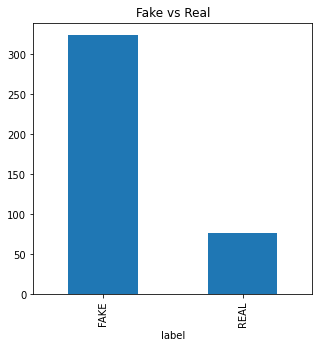

In [10]:
train_sample_metadata.groupby("label")["label"].count().plot(figsize=(5,5), kind="bar", title="Fake vs Real")

<AxesSubplot:title={'center':'Fake vs Real'}>

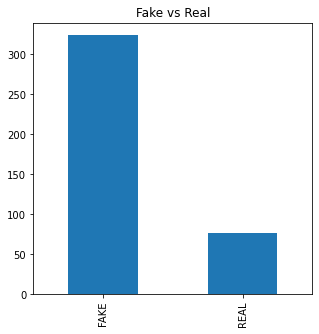

In [11]:
train_sample_metadata["label"].value_counts().plot(figsize=(5,5), kind="bar", title="Fake vs Real")

In [12]:
train_sample_metadata.shape

(400, 3)

In [13]:
list(train_sample_metadata.loc[train_sample_metadata.label == "FAKE"].sample(5).index)

['boovltmuwi.mp4',
 'adhsbajydo.mp4',
 'avgiuextiz.mp4',
 'aufmsmnoye.mp4',
 'ckbdwedgmc.mp4']

In [14]:
f_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].sample(5).index)
f_train_sample_video

['eepezmygaq.mp4',
 'abqwwspghj.mp4',
 'awhmfnnjih.mp4',
 'cxfujlvsuw.mp4',
 'ehevsxtecd.mp4']

In [15]:
def capture_image_from_video(video_path):
    capture_image = cv2.VideoCapture(video_path)
    ret, frame = capture_image.read()
    fig = plt.figure(figsize =(10,10))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

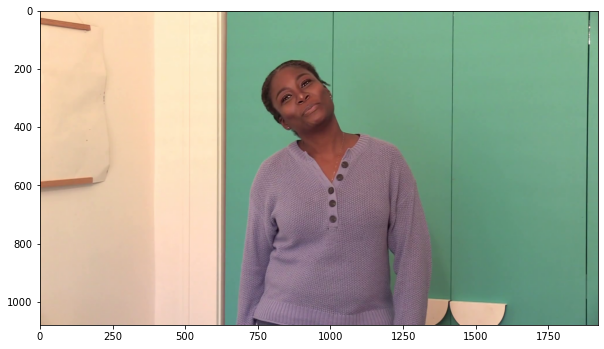

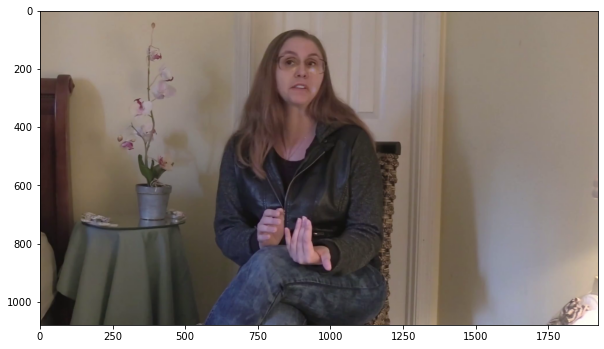

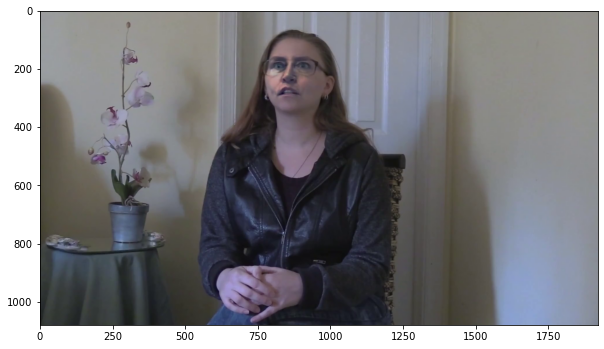

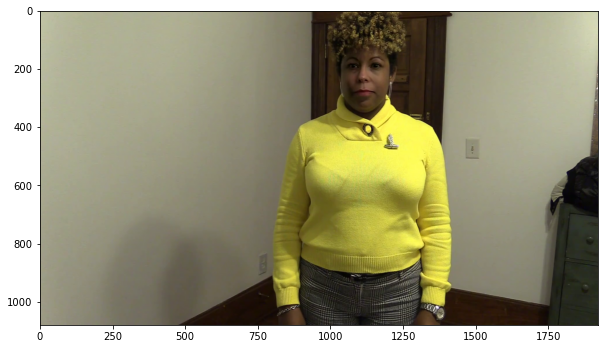

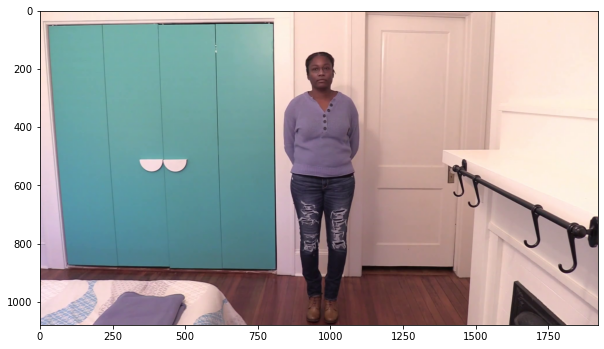

In [16]:
for video_file in f_train_sample_video:
    capture_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

In [17]:
r_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='REAL'].sample(5).index)
r_train_sample_video

['bwhlgysghg.mp4',
 'egghxjjmfg.mp4',
 'bmjzrlszhi.mp4',
 'ekcrtigpab.mp4',
 'eudeqjhdfd.mp4']

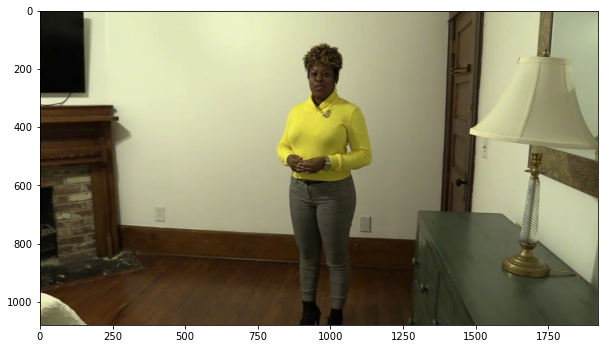

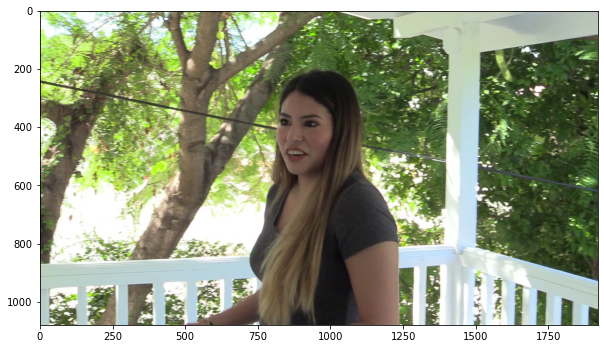

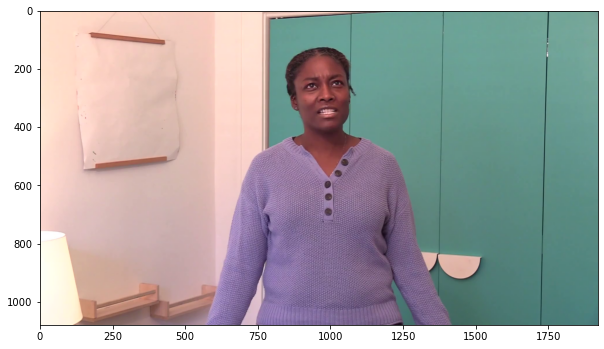

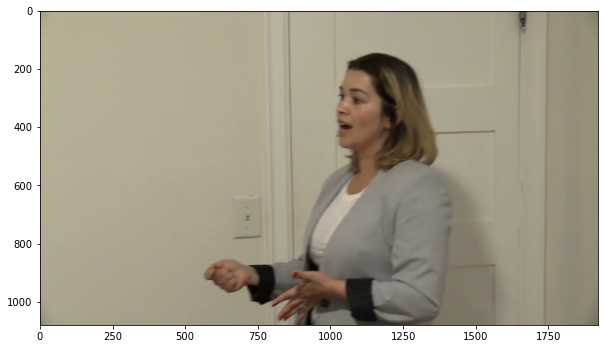

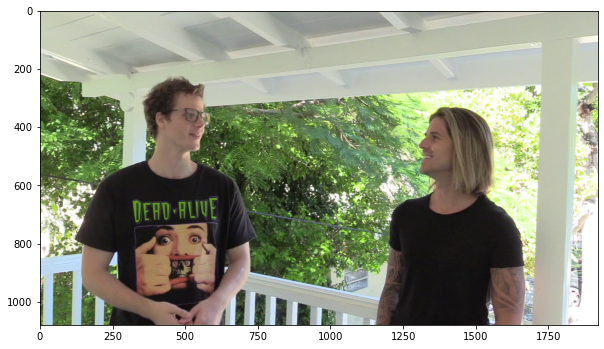

In [18]:
for video_file in r_train_sample_video:
    capture_image_from_video(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER,video_file))

In [19]:
f_videos = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].index)
f_videos[:5]

['aagfhgtpmv.mp4',
 'aapnvogymq.mp4',
 'abofeumbvv.mp4',
 'abqwwspghj.mp4',
 'acifjvzvpm.mp4']

In [20]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file,subset=TRAIN_SAMPLE_FOLDER):
    video_url = open(os.path.join(DATA_FOLDER,subset,video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" %data_url)
play_video(f_videos[5])

In [21]:
img_size = 224
batch_size = 64
epochs = 15

max_seq_length = 20
num_features = 2048

In [22]:
def crop_center_square(frame):
    y,x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y :start_y + min_dim, start_x : start_x + min_dim]

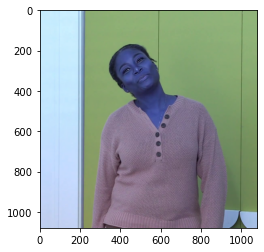

In [37]:
# Example
# capture_image_from_video(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER,"eepezmygaq.mp4"))
capture_image = cv2.VideoCapture(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER,"eepezmygaq.mp4"))
ret, frame = capture_image.read()
frame = crop_center_square(frame)
plt.imshow(frame)

In [38]:
def load_video(path, max_frames=0, resize=(img_size, img_size)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while 1:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [42]:
def pretrain_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet", include_top=False, pooling="avg", input_shape=(img_size, img_size,3)
    )
    
    preprocess_input = keras.applications.inception_v3.preprocess_input
    
    inputs = keras.Input((img_size, img_size, 3))
    preprocessed = preprocess_input(inputs)
    
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name = "feature_extractor")

feature_extractor = pretrain_feature_extractor()

In [43]:
def prepare_all_videos(df, root_dir): #df is the split of train_sample_metadata->json
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df["label"].values
    labels = np.array(labels=='FAKE').astype(np.int)
    
    frame_masks = np.zeros(shape=(num_samples, max_seq_length), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, max_seq_length, num_features), dtype="float32"
    )
    
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        
        temp_frame_mask = np.zeros(shape=(1, max_seq_length,), dtype="bool")
        temp_frame_features = np.zeros(shape=(1, max_seq_length, num_features), dtype="float32")
        
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(max_seq_length, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] =feature_extractor.predict(batch[None, j, :])
            temp_frame_mask[i, :length] =1 # 1 = not masked, 0 = masked
        
        frame_features[idx,] =temp_frame_features.squeeze()
        frame_masks[idx,] =temp_frame_mask.squeeze()
    
    return (frame_features, frame_masks), labels

In [44]:
from sklearn.model_selection import train_test_split

Train_set , Test_set = train_test_split(train_sample_metadata, test_size=0.1,random_state=42,
                                       stratify=train_sample_metadata['label'])
print(Train_set.shape, Test_set.shape)

(360, 3) (40, 3)


In [45]:
train_data, train_labels = prepare_all_videos(Train_set, "train")
test_data, test_labels = prepare_all_videos(Test_set, "test")

print(f"Frame features in train set:{train_data[0].shape}")
print(f"Frame masks in train set:{train_data[1].shape}")

C:\Users\nikhi\AppData\Local\Temp/ipykernel_13872/3662303370.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array(labels=='FAKE').astype(np.int)


Frame features in train set:(360, 20, 2048)
Frame masks in train set:(360, 20)


In [46]:
frame_features_input = keras.Input((max_seq_length, num_features))
mask_input = keras.Input((max_seq_length,),dtype="bool")

x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask = mask_input)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([frame_features_input, mask_input], output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 16)       99168       ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 8)            624         ['gru[0][0]']                

In [47]:
checkpoint = keras.callbacks.ModelCheckpoint('./', save_weights_only=True, save_best_only=True)
history = model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([test_data[0], test_data[1]], test_labels),
        callbacks=[checkpoint],
        epochs=25,
        batch_size=8
)

Epoch 1/25
45/45 [==============================] - 18s 130ms/step - loss: 0.6872 - accuracy: 0.7917 - val_loss: 0.6815 - val_accuracy: 0.8000
Epoch 2/25
45/45 [==============================] - 1s 29ms/step - loss: 0.6753 - accuracy: 0.8083 - val_loss: 0.6697 - val_accuracy: 0.8000
Epoch 3/25
45/45 [==============================] - 1s 29ms/step - loss: 0.6638 - accuracy: 0.8083 - val_loss: 0.6590 - val_accuracy: 0.8000
Epoch 4/25
45/45 [==============================] - 1s 30ms/step - loss: 0.6529 - accuracy: 0.8083 - val_loss: 0.6491 - val_accuracy: 0.8000
Epoch 5/25
45/45 [==============================] - 1s 28ms/step - loss: 0.6426 - accuracy: 0.8083 - val_loss: 0.6391 - val_accuracy: 0.8000
Epoch 6/25
45/45 [==============================] - 1s 28ms/step - loss: 0.6329 - accuracy: 0.8083 - val_loss: 0.6298 - val_accuracy: 0.8000
Epoch 7/25
45/45 [==============================] - 1s 27ms/step - loss: 0.6236 - accuracy: 0.8083 - val_loss: 0.6213 - val_accuracy: 0.8000
Epoch 8/25


In [48]:
test_videos = pd.DataFrame(list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER))), columns=['video'])

In [49]:
test_videos

video
0    aassnaulhq.mp4
1    aayfryxljh.mp4
2    acazlolrpz.mp4
3    adohdulfwb.mp4
4    ahjnxtiamx.mp4
..              ...
395  ztyvglkcsf.mp4
396  zuwwbbusgl.mp4
397  zxacihctqp.mp4
398  zyufpqvpyu.mp4
399  zzmgnglanj.mp4

[400 rows x 1 columns]

In [51]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, max_seq_length,), dtype="bool")
    frame_features = np.zeros(shape=(1, max_seq_length, num_features), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(max_seq_length, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(DATA_FOLDER, TEST_FOLDER,path))
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask])[0]
    
# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

test_videos_list = test_videos["video"].values.tolist()
test_videos_selected = np.random.choice(test_videos_list, size=2, replace=False)

print(f"Test video path: {test_videos}")

# if(sequence_prediction(test_video)>=0.5):
#     print(f'The predicted class of the video is FAKE')
# else:
#     print(f'The predicted class of the video is REAL')

# play_video(test_video,TEST_FOLDER)

Test video path:               video
0    aassnaulhq.mp4
1    aayfryxljh.mp4
2    acazlolrpz.mp4
3    adohdulfwb.mp4
4    ahjnxtiamx.mp4
..              ...
395  ztyvglkcsf.mp4
396  zuwwbbusgl.mp4
397  zxacihctqp.mp4
398  zyufpqvpyu.mp4
399  zzmgnglanj.mp4

[400 rows x 1 columns]


In [52]:
if(sequence_prediction("test_videos/aassnaulhq.mp4") >=0.5):
    print("Fake")

1/1 [==============================] - 6s 6s/step
Fake
